O __objetivo__ aqui será construir um algoritmo que faça a __predição se um dígito é par ou ímpar.__

Para isso, faça um tratamento inicial na variável target.

Use a __AUC__ como métrica de performance.

Teste diferentes versões do KNN-Classifier, bem como a regressão logística. 

Use a __metodologia de validação cruzada__, implementando manualmente a AUC, conforme feito nas aulas.

Plote as __curvas ROC__ dos algoritmos.

In [1]:
import warnings

warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
X, y = mnist['data'], mnist['target'].astype(float)

X.shape, y.shape


((70000, 784), (70000,))

In [2]:
# Separando o dataset

Xtrain, Xtest, ytrain, ytest = X[:55000], X[55000:], y[:55000], y[55000:]


In [3]:
# Setando a condição True para a validação do números pares

ytrain_par = np.where(ytrain % 2 == 0, 1, 0)
ytest_par = np.where(ytest % 2 == 0, 1, 0)

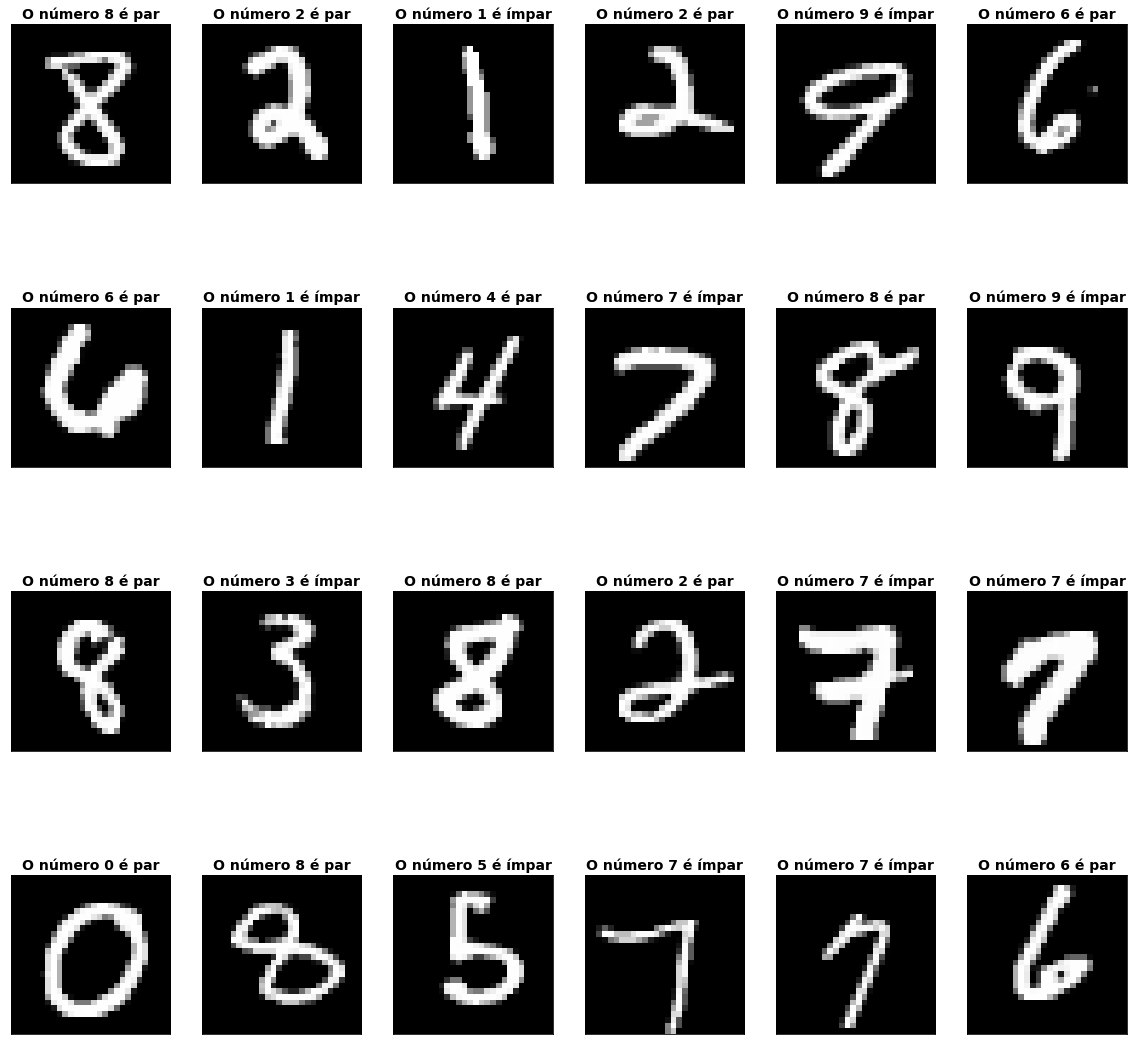

In [4]:
random_idx = np.random.randint(0, Xtrain.shape[0], size=24)

plt.figure(figsize=[20,20])

for i in range(len(random_idx)):
    idx_i = random_idx[i]
    
    xval = Xtrain[idx_i, :].reshape(28,28)
    yval = ytrain[idx_i]
    yval_par = ytrain_par[idx_i]

    plt.subplot(4,6, i+1)
    plt.imshow(xval, cmap=plt.cm.Greys_r)
    plt.xticks([])
    plt.yticks([])

    if yval_par:
        result = "par"
    else:
        result = "ímpar"

    plt.title('O número ' + str(int(yval)) + ' é '+ str(result), fontsize=14, fontweight='bold')



In [5]:
# Regressão Logística

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score

def classificador_logistico(X_train, y_train, print_info=True):
    logreg = LogisticRegression()   

    logreg.fit(X_train, y_train)

    ytrain_pred = logreg.predict(Xtrain)
    ytrain_prob = logreg.predict_proba(Xtrain) 

    if print_info:
        print(f"Inrtercept: {logreg.intercept_}")
        print(f"Coef size: {logreg.coef_.size}")
        print(f'A precisão da regressão logística é de {accuracy_score(ytrain_par, ytrain_pred).round(3)} %')
        print(f"Predições: {ytrain_pred}")

    return logreg, ytrain_pred, ytrain_prob

logreg, ytrain_pred, ytrain_prob =  classificador_logistico(Xtrain, ytrain_par)
    

Inrtercept: [-0.00096028]
Coef size: 784
A precisão da regressão logística é de 0.899 %
Predições: [0 1 1 ... 1 1 1]


In [6]:
from sklearn.model_selection import cross_val_predict

ytrain_scores = cross_val_predict(logreg, Xtrain, ytrain_par, cv=3, method='decision_function')
ytrain_scores

array([-6.44456716,  2.26379557,  0.64755472, ...,  5.11758212,
        0.33133532,  4.80132863])

In [7]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(ytrain_par, ytrain_scores)


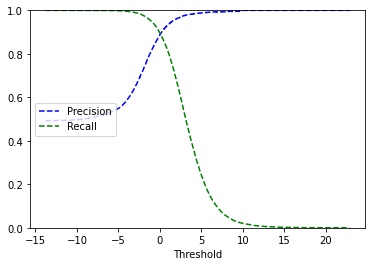

In [8]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0,1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()



In [9]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(ytrain_par, ytrain_scores)

In [10]:
from sklearn.metrics import roc_auc_score

print(f"O modelo de regressão logística tem {roc_auc_score(ytrain_par, ytrain_scores).round(3)} % de precisão.")

O modelo de regressão logística tem 0.956 % de precisão.


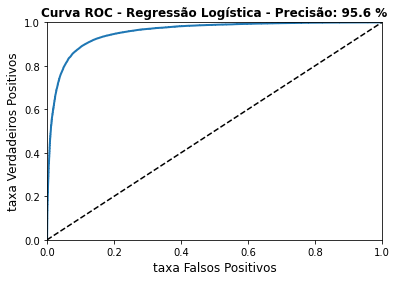

In [11]:
def plot_roc_curve(fpr, tpr, label=None, title=None):
    #plt.figure(figsize=[10,10])
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('taxa Falsos Positivos', fontsize=12)
    plt.ylabel('taxa Verdadeiros Positivos', fontsize=12)
    plt.title(title, fontweight='bold', fontsize=12)  

plot_roc_curve(fpr, tpr, title=f'Curva ROC - Regressão Logística - Precisão: {roc_auc_score(ytrain_par, ytrain_scores).round(3)*100} %')
plt.show()

In [12]:
# Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
ytrain_probas_forest = cross_val_predict(forest_clf, Xtrain, ytrain_par, cv=3, method='predict_proba')

In [13]:
ytrain_scores_forest = ytrain_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(ytrain_par, ytrain_scores_forest)

In [14]:
forest_score = roc_auc_score(ytrain_par, ytrain_scores_forest)
print(f"O modelo de regressão logística tem {forest_score.round(3)} % de precisão.")

O modelo de regressão logística tem 0.997 % de precisão.


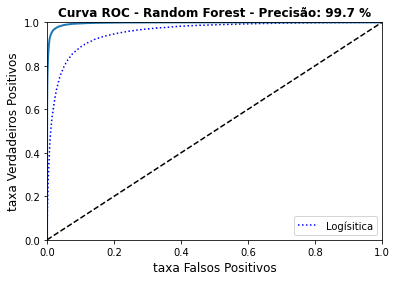

In [15]:
plt.plot(fpr, tpr, 'b:', label='Logísitica')
plot_roc_curve(fpr_forest, tpr_forest, title=f'Curva ROC - Random Forest - Precisão: {roc_auc_score(ytrain_par, ytrain_scores_forest).round(3)*100} %')
plt.legend(loc='lower right')
plt.show()

In [16]:
# KNN
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()


In [17]:
from sklearn.model_selection import GridSearchCV

grid_params = {
    'n_neighbors': [3, 5, 11, 19],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhatthan']
}

gs = GridSearchCV(
    knn_clf,
    grid_params,
    verbose = 1,
    cv = 3,
    n_jobs = -1
)

gs.results = gs.fit(Xtrain, ytrain_par)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 332.8min finished


In [ ]:
gs.best_params_

In [ ]:
knn_clf = KNeighborsClassifier(n_neighbors=)

In [ ]:
ytrain_probas_knn = cross_val_predict(knn_clf, Xtrain, ytrain_par, cv=3, method='predict_proba')

In [ ]:
ytrain_scores_knn = ytrain_probas_knn[:, 1]
fpr_knn, tpr_knn, thresholds_knn = roc_curve(ytrain_par, ytrain_scores_knn)

In [ ]:
knn_score = roc_auc_score(ytrain_par, ytrain_scores_knn)
print(f"O modelo K-Neighbors tem {knn_score.round(3)} % de precisão.")

O modelo de regressão logística tem 0.995 % de precisão.


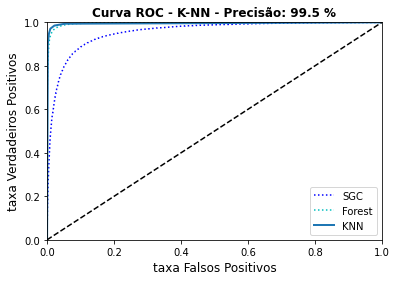

In [ ]:
plt.plot(fpr, tpr, 'b:', label='SGC')
plt.plot(fpr_forest, tpr_forest, 'c:', label='Forest')
plot_roc_curve(fpr_knn, tpr_knn, title=f'Curva ROC - K-Neighbors - Precisão: {roc_auc_score(ytrain_par, ytrain_scores_knn).round(3)*100} %', label='KNN')
plt.legend(loc='lower right')
plt.show()

In [ ]:
print(f'Train Score: {knn_clf.score(Xtrain, ytrain_par)}')
print(f"Test score: {knn_clf.score(Xtest, ytest_par)}")


Train Score: 0.9893818181818181


NameError: name 'ytest_oar' is not defined

In [ ]:
# Avaliando o sistema no conjunto de testes

final_model = grid_search.best_estimator_

final_predictions = final_model.predict(Xtest)
final_score = 